# Verify alphafold accuracy and pLDDT performance

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from IPython.display import display
from pathlib import Path

In [2]:
data_dir = Path('../../../data/out/') / 'test'
score_dir = data_dir / 'score'
label_dir = score_dir / 'label'
fig_dir = data_dir / 'score' /'fig' / 'alphafold'

In [3]:
part_label_path = score_dir / 'label_8targets.csv'
if not part_label_path.exists():
    df = pd.concat([pd.read_csv(label, index_col=0) for label in label_dir.glob('*.csv')])
    df.to_csv(part_label_path)
else:
    df = pd.read_csv(part_label_path, index_col=0)
df['Ensemble'] = [True if e == 8 else False for e in df['Ensemble']]
df

Model  GDT_TS  GDT_HA  TMscore  Global_LDDT  \
0    model_5_ptm_seed_0_rec_10_ens_1   0.967   0.959    0.862        0.893   
1     model_5_ptm_seed_0_rec_9_ens_1   0.967   0.959    0.860        0.893   
2     model_5_ptm_seed_1_rec_9_ens_8   0.967   0.959    0.859        0.893   
3     model_5_ptm_seed_0_rec_8_ens_1   0.967   0.960    0.862        0.892   
4     model_5_ptm_seed_0_rec_6_ens_1   0.967   0.957    0.855        0.893   
..                               ...     ...     ...      ...          ...   
395       model_5_seed_1_rec_9_ens_8   0.976   0.943    0.803        0.908   
396      model_4_seed_1_rec_10_ens_8   0.976   0.947    0.810        0.904   
397       model_4_seed_1_rec_9_ens_1   0.977   0.950    0.816        0.906   
398      model_4_seed_1_rec_10_ens_1   0.977   0.951    0.815        0.905   
399      model_5_seed_1_rec_10_ens_8   0.977   0.944    0.806        0.908   

     Mean_LDDT  pLDDT  pTMscore  Tolerance    ModelName  Seed  Recycle  \
0        0.890  0.976     0.909      0.024  model_5_ptm     0       10   
1        0.891  0.975     0.909      0.025  model_5_ptm     0        9   
2        0.891  0.976     0.910      0.021  model_5_ptm     1        9   
3        0.890  0.974     0.908      0.022  model_5_ptm     0        8   
4        0.890  0.975     0.908      0.020  model_5_ptm     0        6   
..         ...    ...       ...        ...          ...   ...      ...   
395        NaN  0.924       NaN      0.023      model_5     1        9   
396        NaN  0.928       NaN      0.022      model_4     1       10   
397        NaN  0.927       NaN      0.045      model_4     1        9   
398        NaN  0.928       NaN      0.033      model_4     1       10   
399        NaN  0.924       NaN      0.019      model_5     1       10   

     Ensemble  Target  
0       False  6II1_D  
1       False  6II1_D  
2        True  6II1_D  
3       False  6II1_D  
4       False  6II1_D  
..        ...     ...  
395      True  6AXS_A  
396      True  6AXS_A  
397     False  6AXS_A  
398     False  6AXS_A  
399      True  6AXS_A  

[3200 rows x 14 columns]

## GDT_TS and pLDDT distribution

In [4]:
def boxplot_labels(df, labels, y='Target', figsize=(10, 8)):
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), sharex=False, sharey=True, figsize=figsize)
    for i, label in enumerate(labels):
        sns.boxplot(data=df, y=y, x=label, ax=axes[i])
    for i in range(1, len(axes)):
        axes[i].set_ylabel('')
    plt.tight_layout()

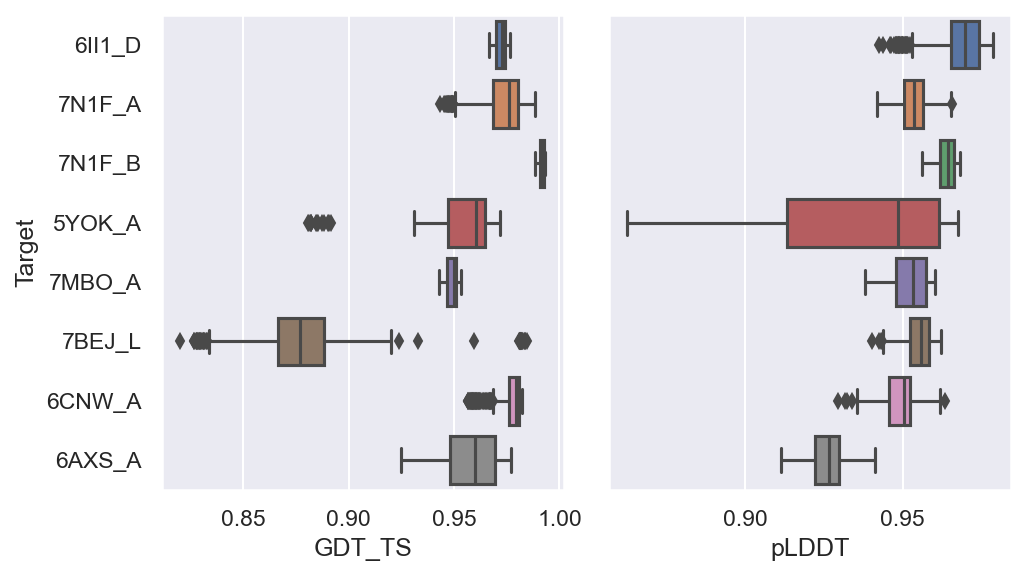

In [5]:
# boxplot of GDT_TS and pLDDT for each target
figsize = (7, 4)
labels = ['GDT_TS', 'pLDDT']
boxplot_labels(df, labels, figsize=figsize)
plt.savefig(fig_dir / 'boxplot_gdtts_plddt.png')

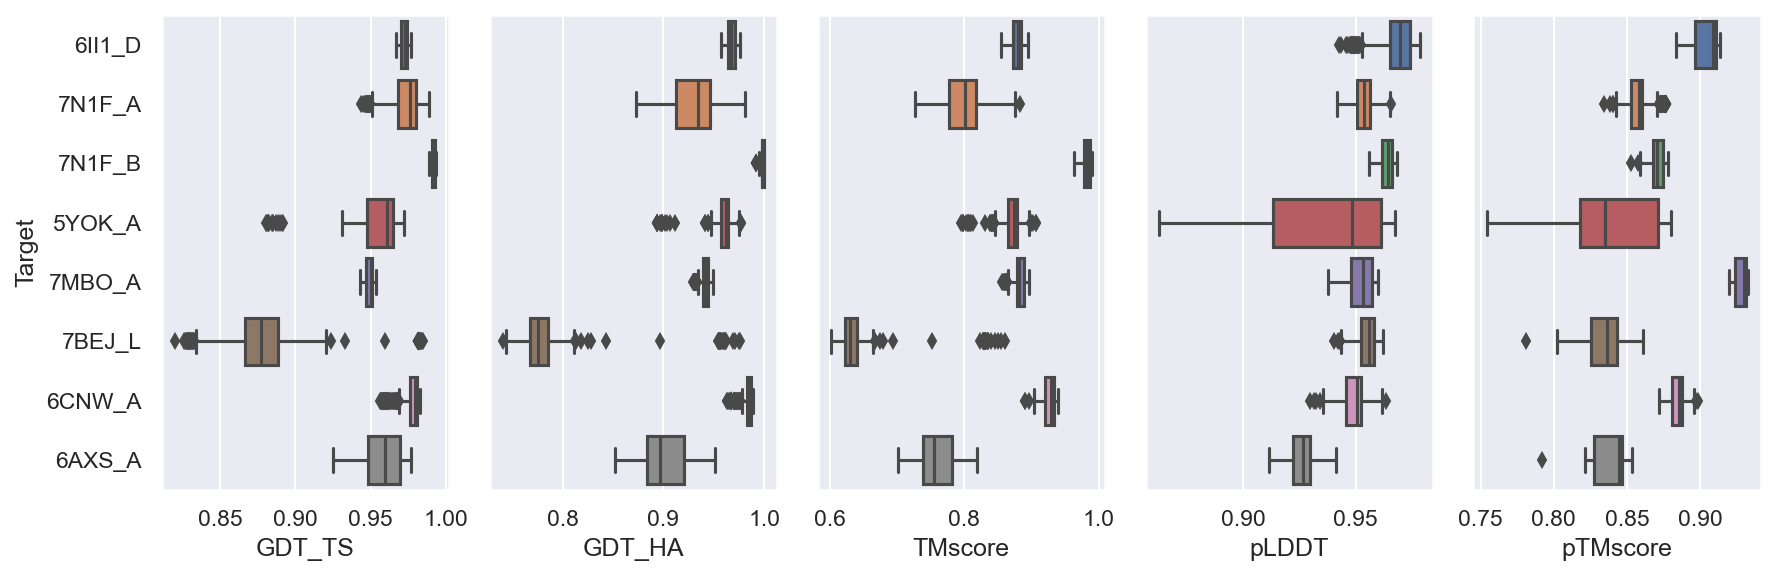

In [6]:
# boxplot of all labels for each target
figsize = (12, 4)
labels = ['GDT_TS', 'GDT_HA', 'TMscore', 'pLDDT', 'pTMscore']
boxplot_labels(df, labels, figsize=figsize)
plt.savefig(fig_dir / 'boxplot_all_metrics.png')

## Scatter plot between GDT_TS and pLDDT

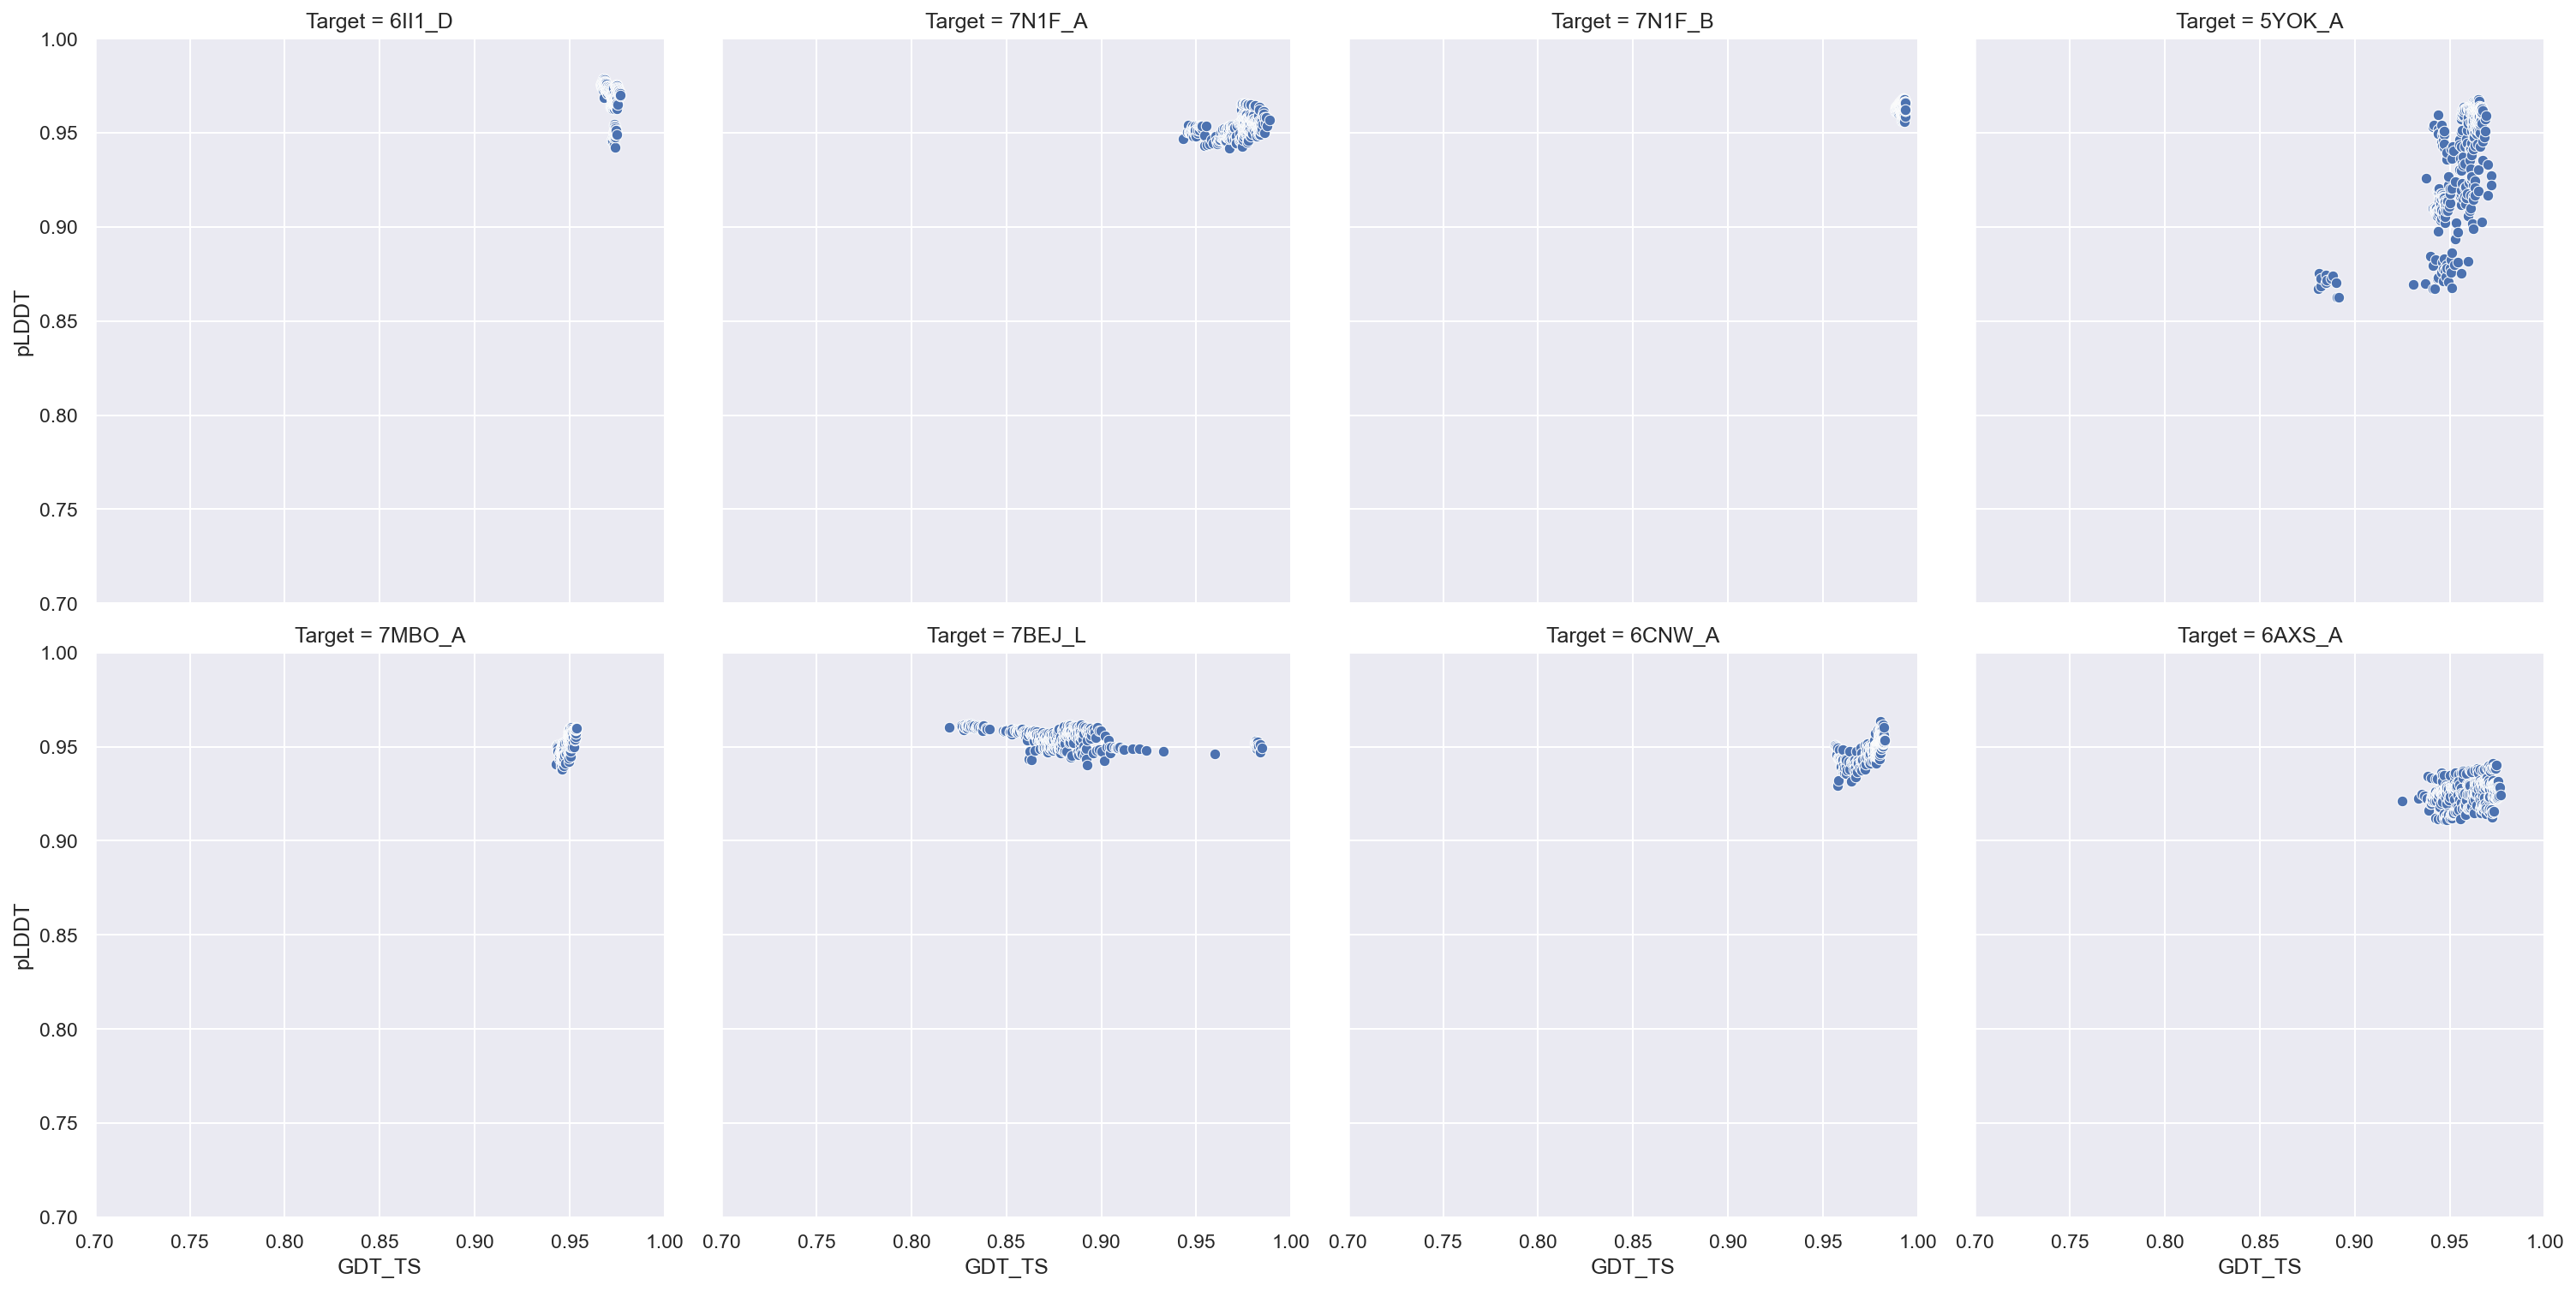

In [7]:
def scatter(df, x, y, col_wrap=4, lim=(0.7, 1)):
    g = sns.relplot(data=df, kind='scatter', x=x, y=y, col='Target', col_wrap=col_wrap)
    g.set(xlim=lim, ylim=lim)
    plt.subplots_adjust(wspace=0.1)
scatter(df, x='GDT_TS', y='pLDDT', col_wrap=4)
plt.savefig(fig_dir / 'scatter_gdtts_plddt.png')

## Verify model accuracy difference between with and without ensemble

In [8]:
en_df = df.query('Ensemble == True')
no_en_df = df.query('Ensemble == False')
en_merge_df = pd.merge(en_df, no_en_df, on=['ModelName', 'Seed', 'Recycle', 'Target'], suffixes=('_en', '_no_en'))

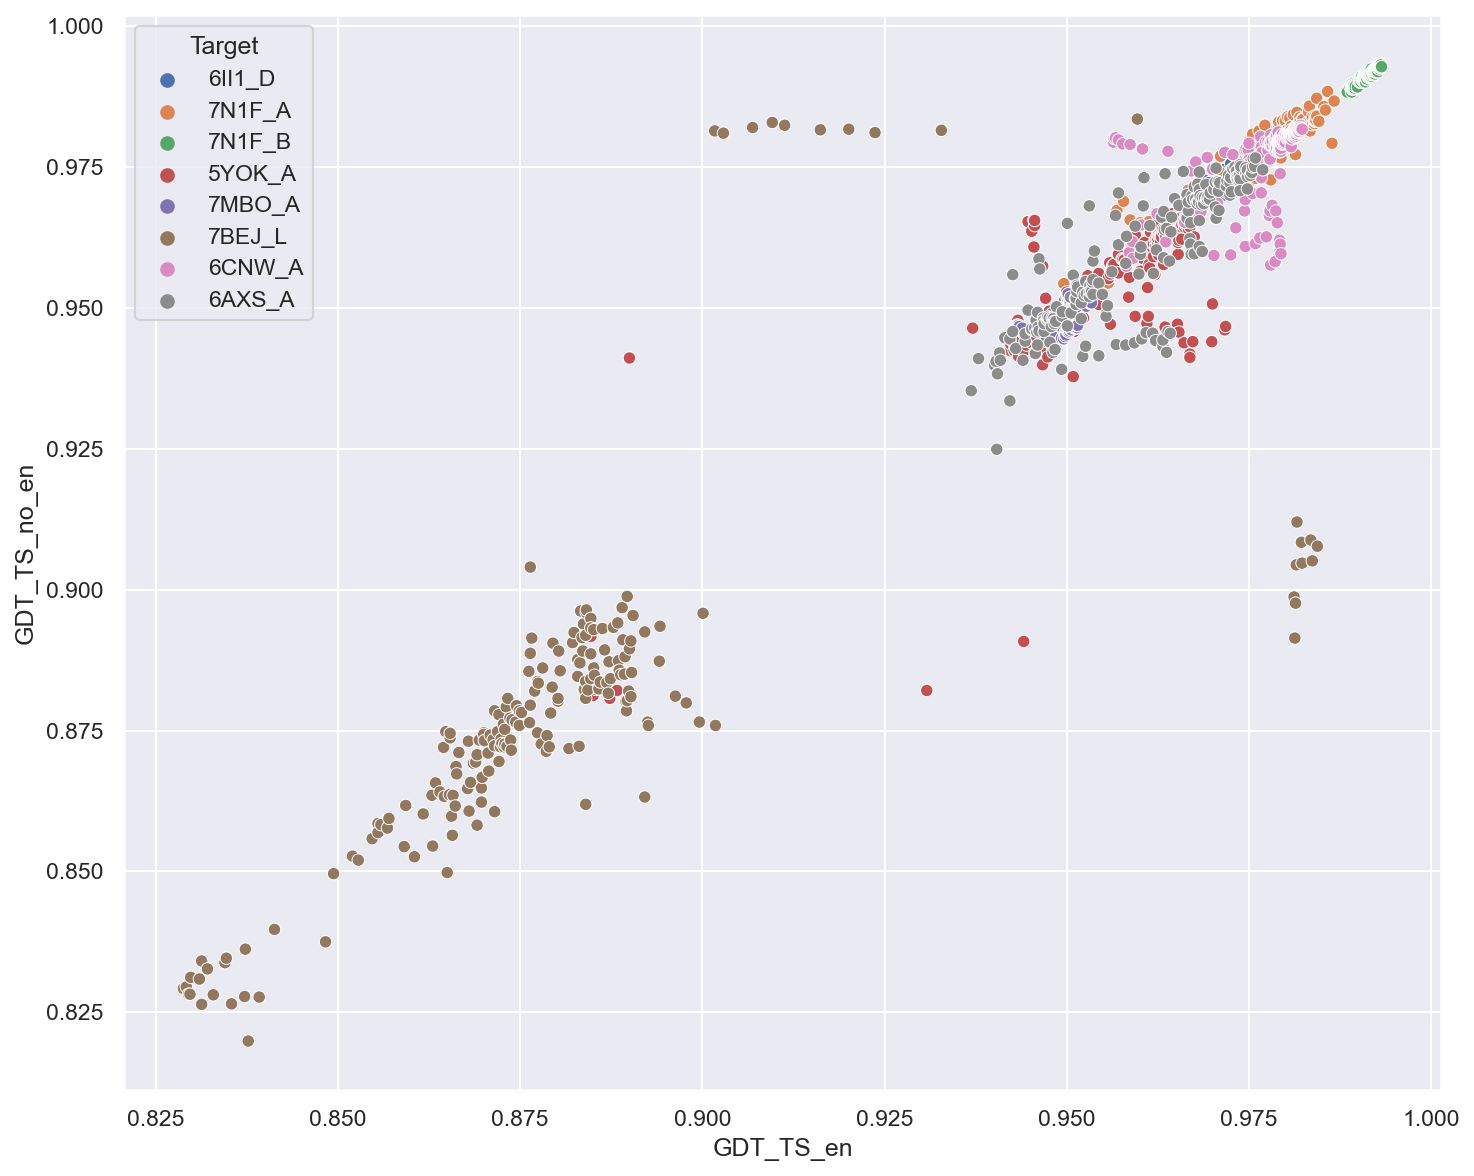

In [9]:
# Scatterplot of GDT_TS of models with and without ensemble
plt.figure(figsize=(10, 8))
label = 'GDT_TS'
sns.scatterplot(data=en_merge_df, x=f'{label}_en', y=f'{label}_no_en', hue='Target')
plt.tight_layout()
plt.savefig(fig_dir / f'scatter_{label}_en_or_no_en.png')

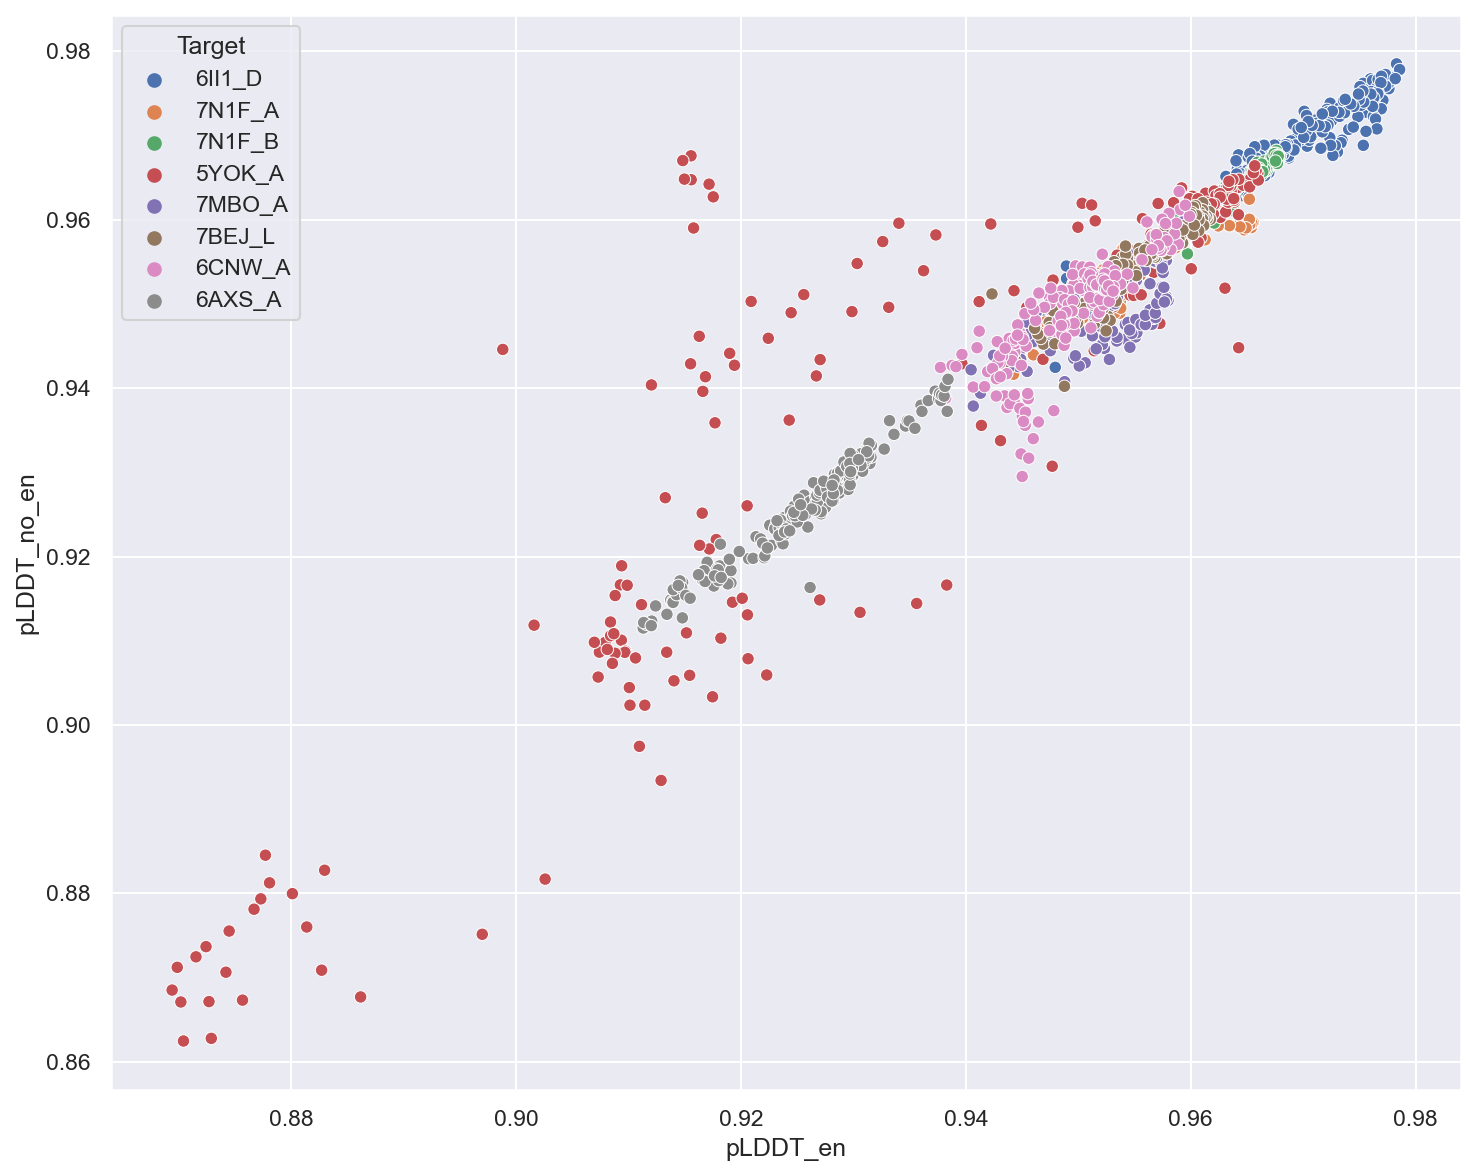

In [10]:
plt.figure(figsize=(10, 8))
label = 'pLDDT'
sns.scatterplot(data=en_merge_df, x=f'{label}_en', y=f'{label}_no_en', hue='Target')
plt.tight_layout()
plt.savefig(fig_dir / f'scatter_{label}_en_or_no_en.png')

## Verify model accuracy difference beween seed 0 and seed 1

In [11]:
seed_0_df = df.query('Seed == 0')
seed_1_df = df.query('Seed == 1')
seed_df = pd.merge(seed_0_df, seed_1_df, on=['ModelName', 'Ensemble', 'Recycle', 'Target'], suffixes=('_seed_0', '_seed_1'))

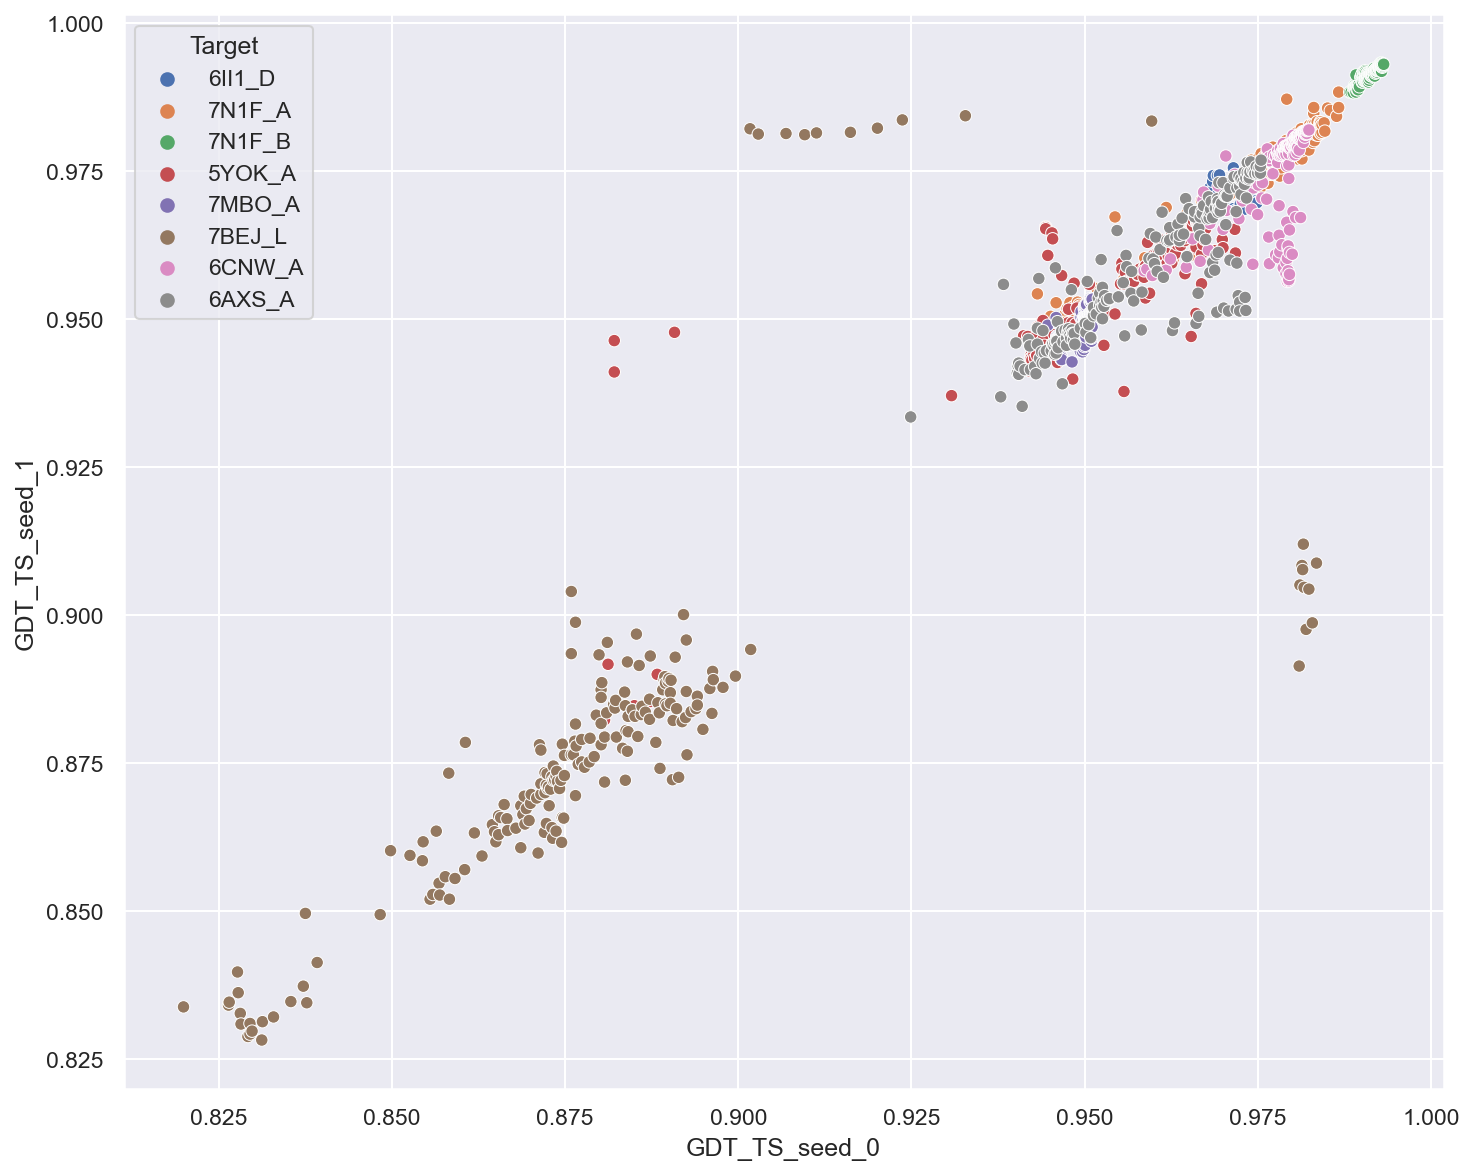

In [12]:
plt.figure(figsize=(10, 8))
label = 'GDT_TS'
sns.scatterplot(data=seed_df, x=f'{label}_seed_0', y=f'{label}_seed_1', hue='Target')
plt.tight_layout()
plt.savefig(fig_dir / f'scatter_{label}_seed.png')

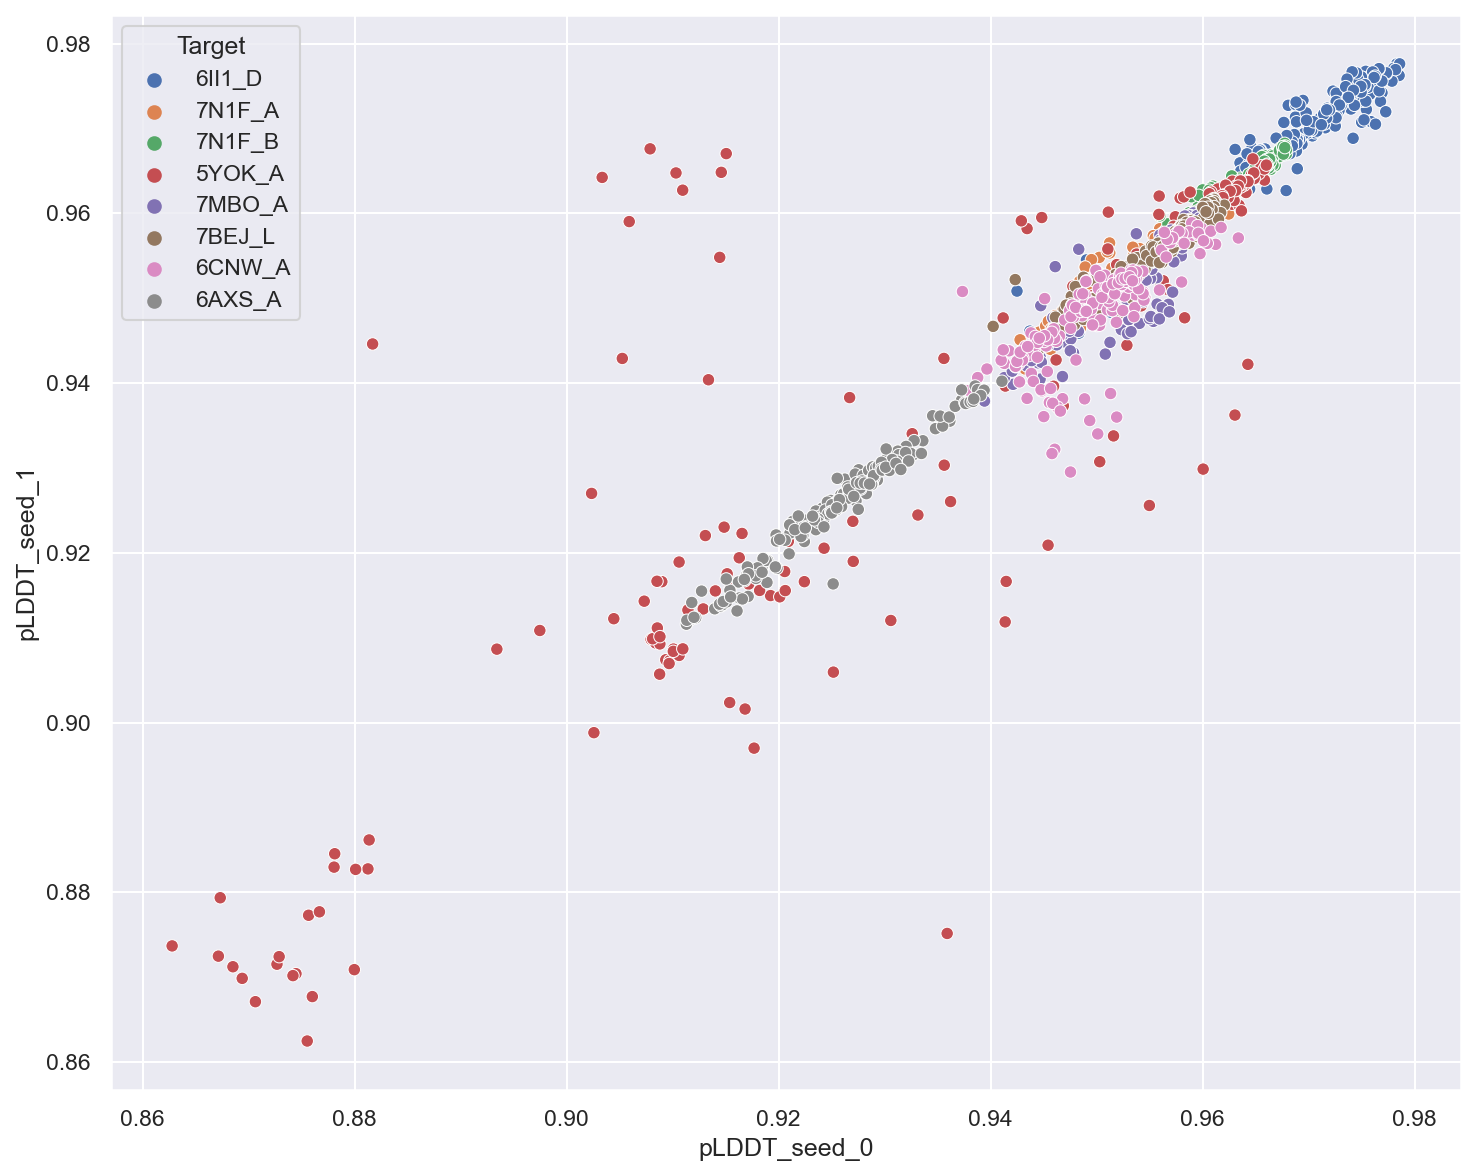

In [13]:
plt.figure(figsize=(10, 8))
label = 'pLDDT'
sns.scatterplot(data=seed_df, x=f'{label}_seed_0', y=f'{label}_seed_1', hue='Target')
plt.tight_layout()
plt.savefig(fig_dir / f'scatter_{label}_seed.png')

## Verify model accuracy difference between recycles

<Figure size 2100x1500 with 0 Axes>

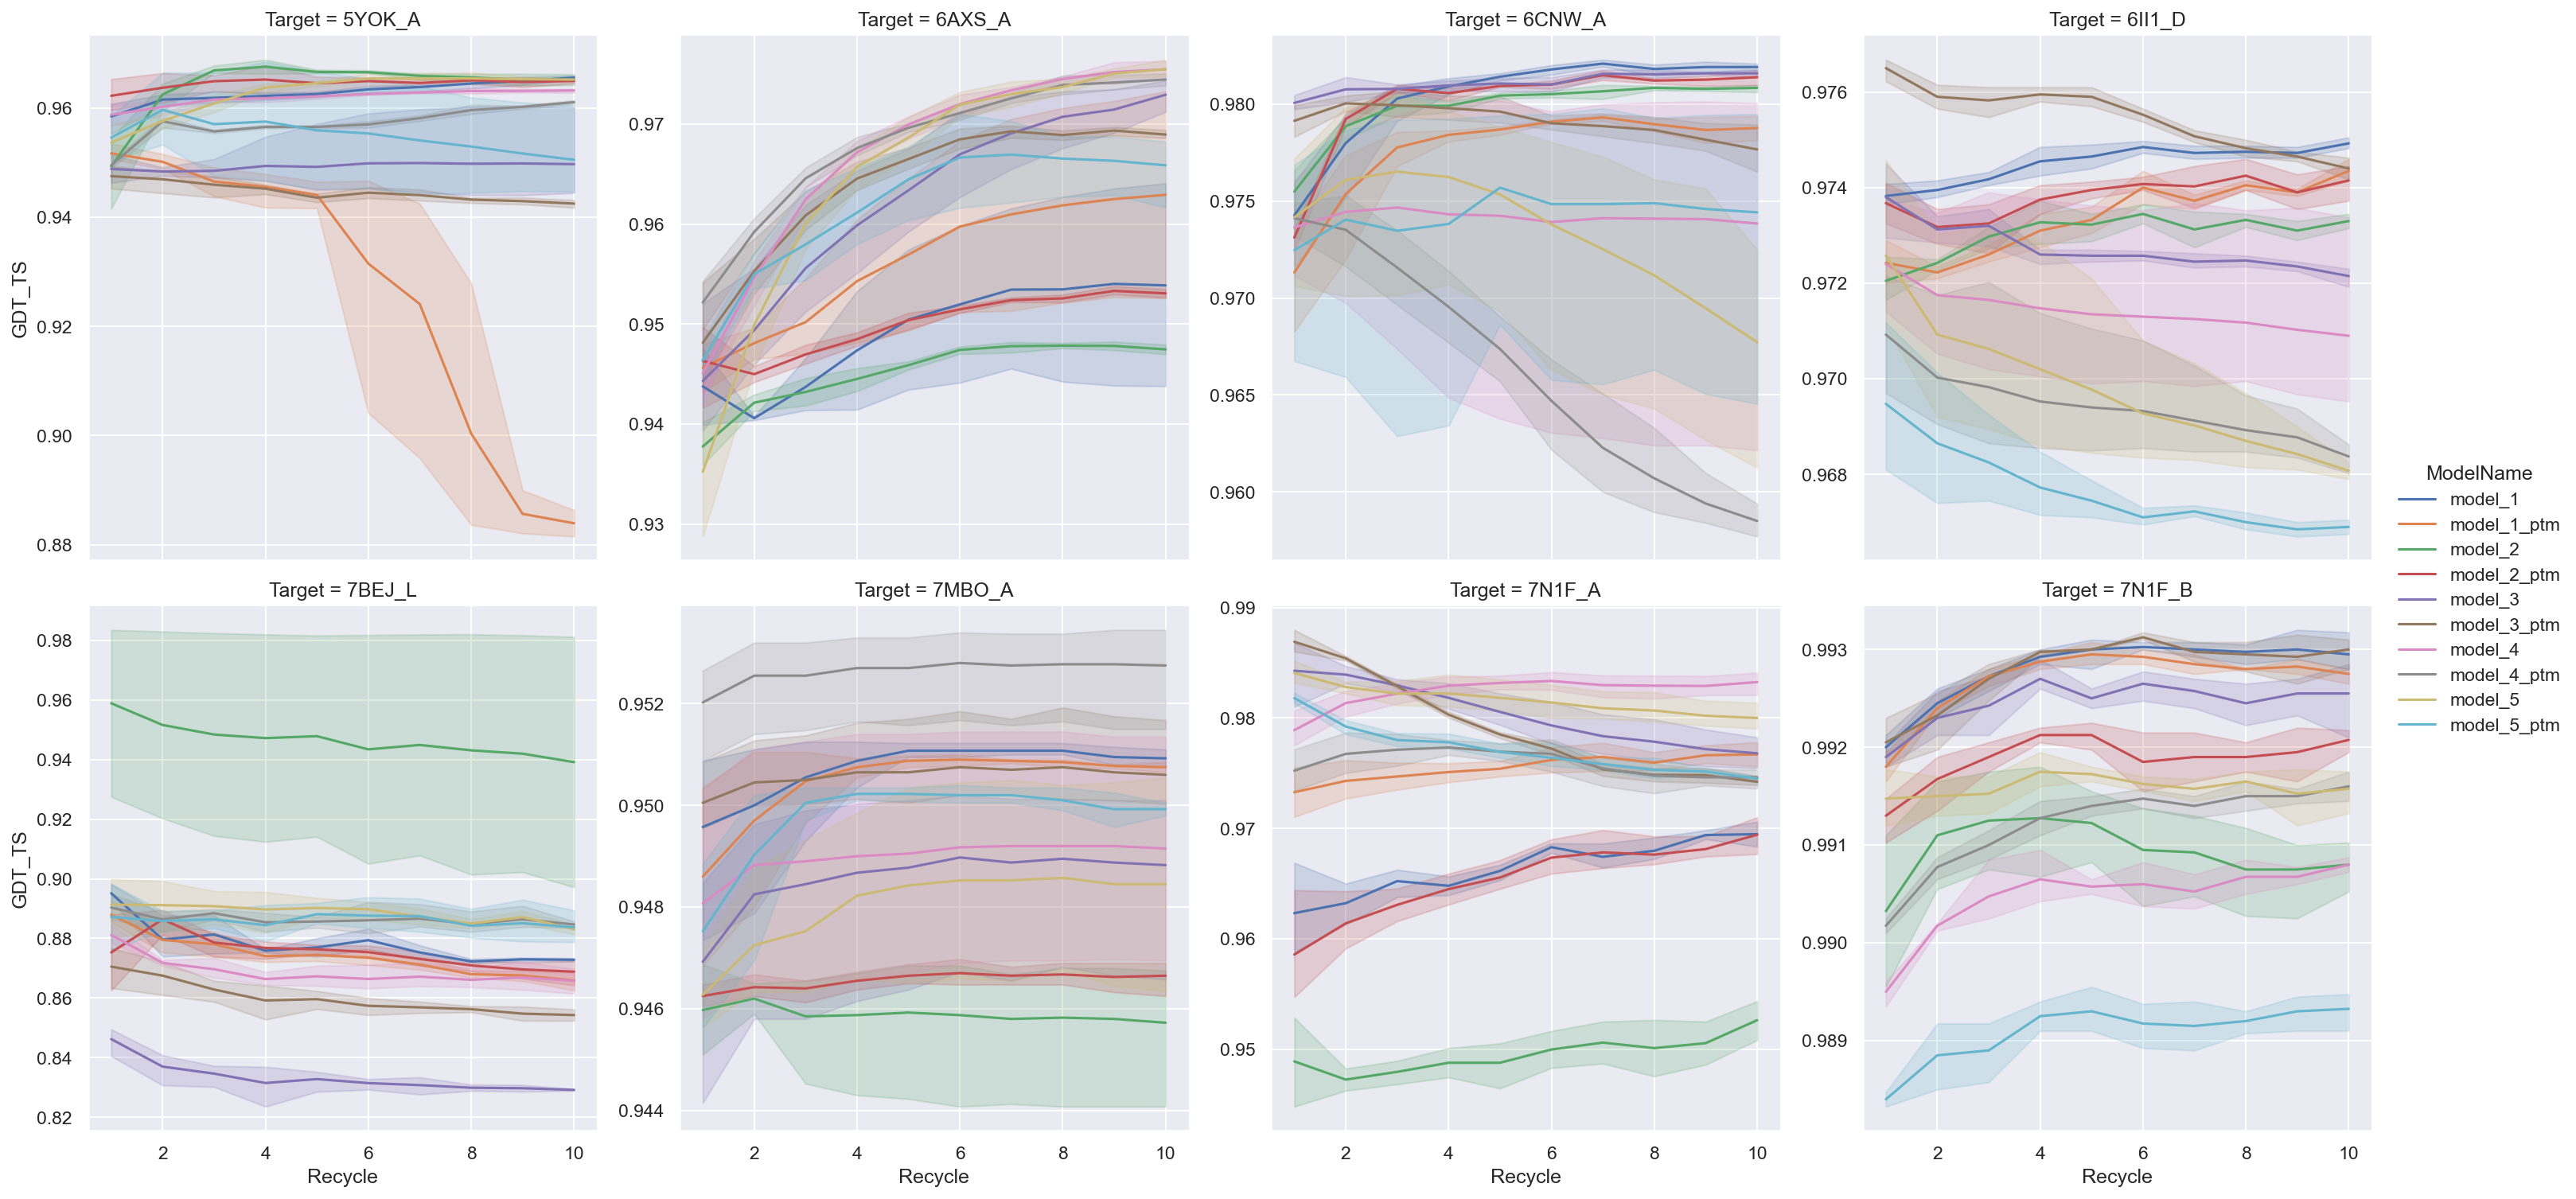

In [14]:
plt.figure(figsize=(14, 10))
sns.relplot(data=df.sort_values(['Target', 'ModelName']), x='Recycle', y='GDT_TS',
            hue='ModelName', kind='line', markers=True, dashes=True,
            col='Target', col_wrap=4, facet_kws={'sharey': False, 'sharex': True})
plt.savefig(fig_dir / 'line_rec_gdtts.png')

<Figure size 2100x1500 with 0 Axes>

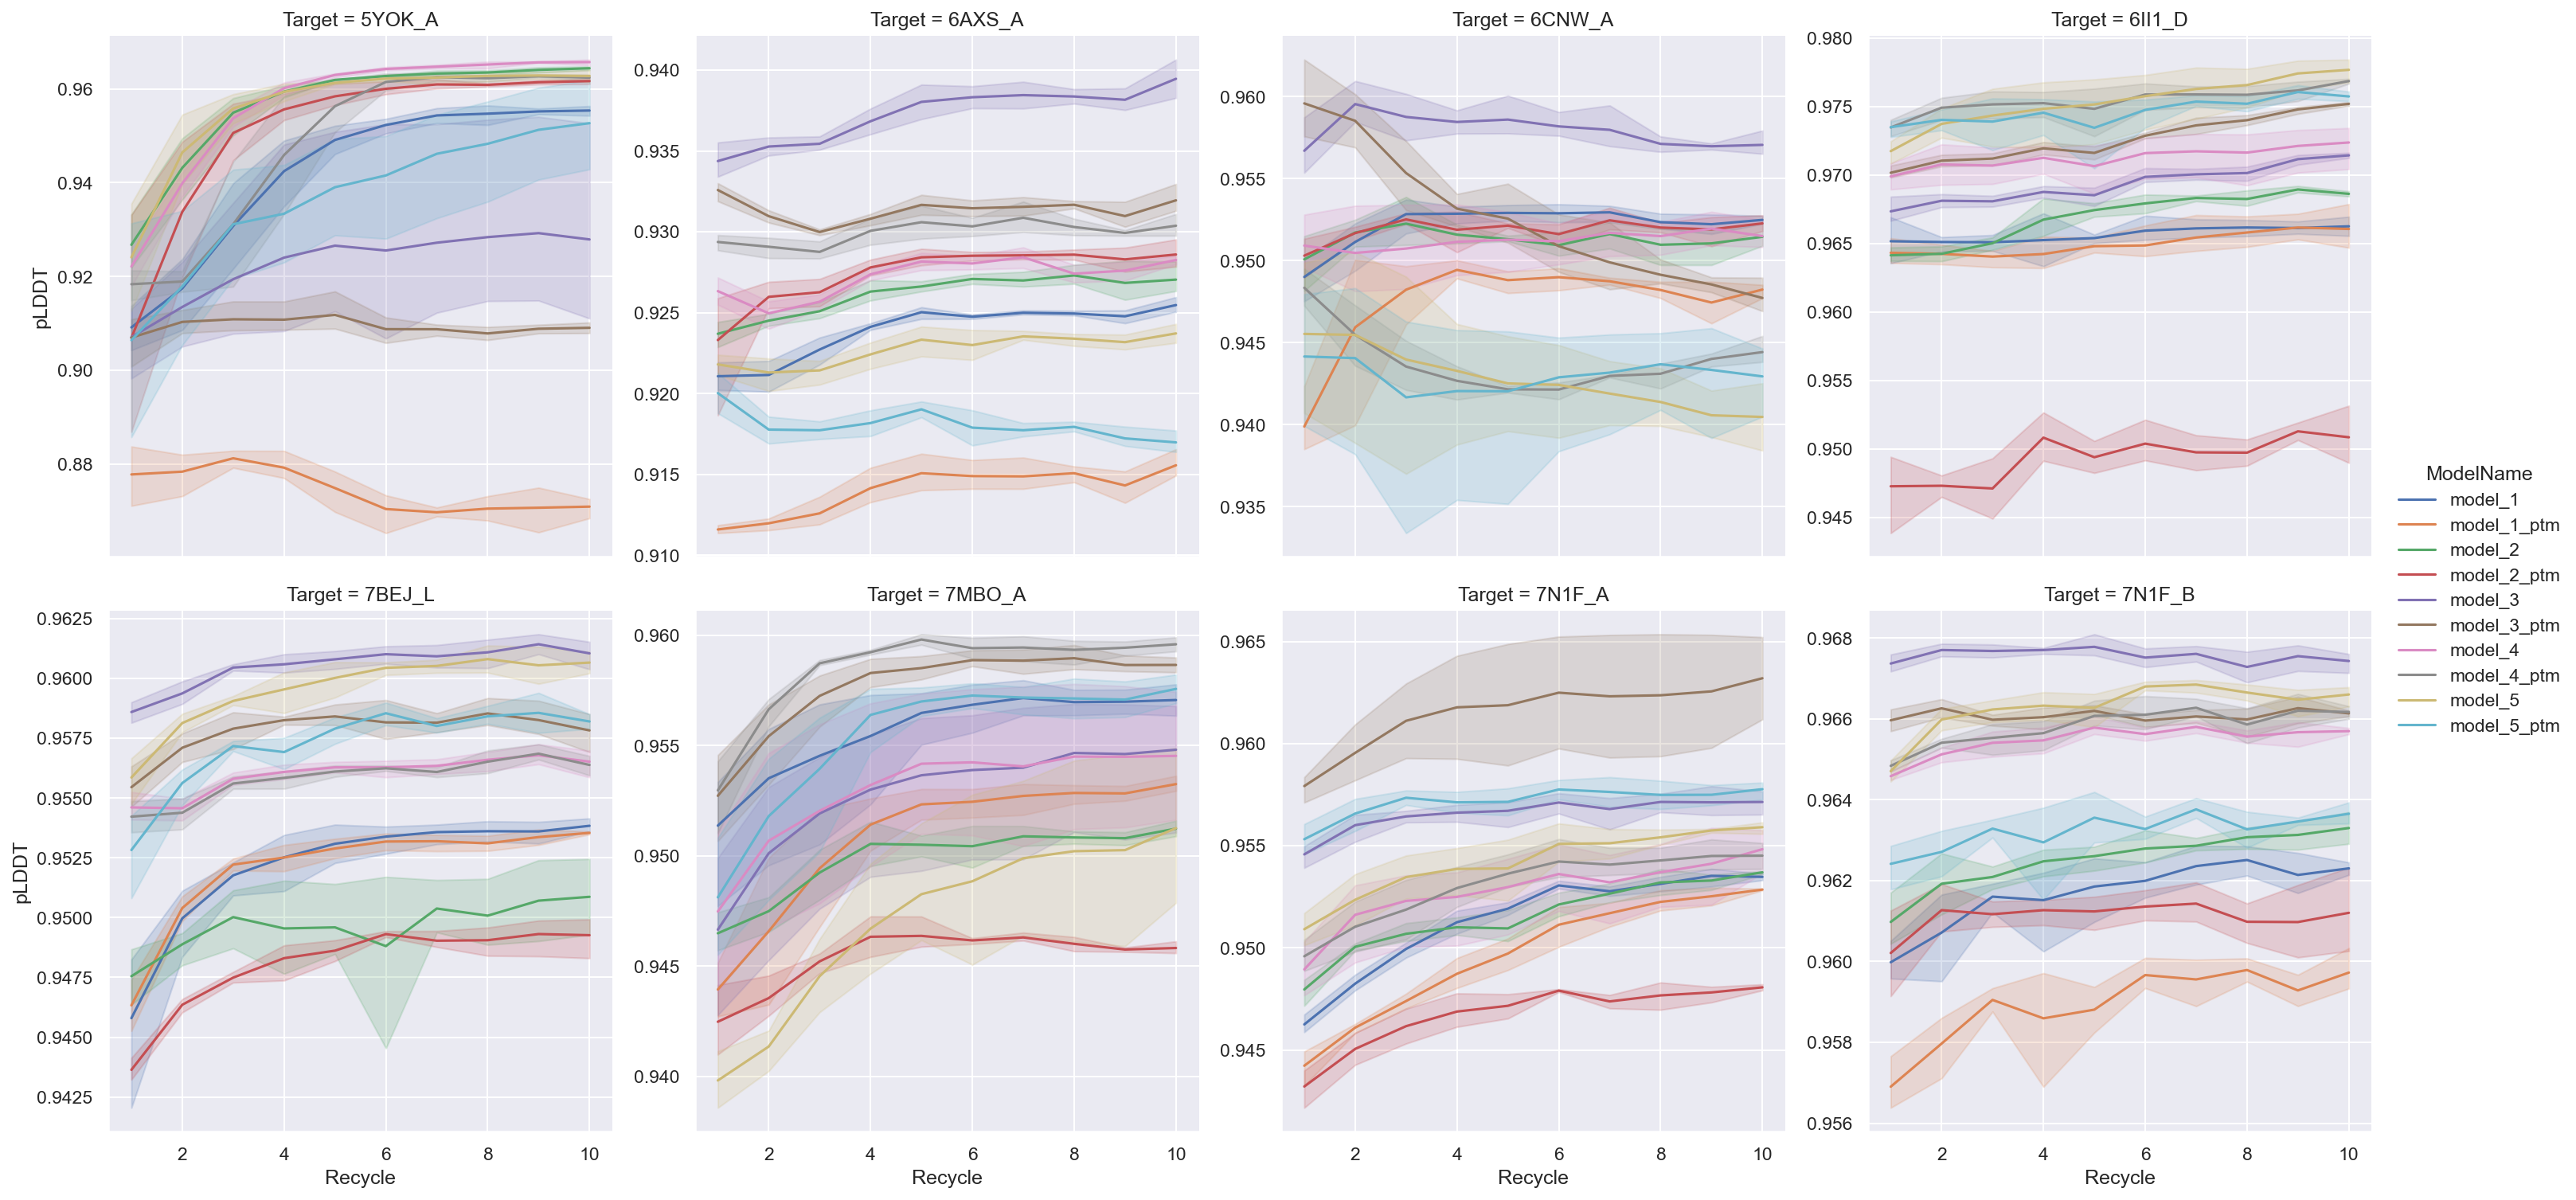

In [15]:
plt.figure(figsize=(14, 10))
sns.relplot(data=df.sort_values(['Target', 'ModelName']), x='Recycle', y='pLDDT',
            hue='ModelName', kind='line', markers=True, dashes=True,
            col='Target', col_wrap=4, facet_kws={'sharey': False, 'sharex': True})
plt.savefig(fig_dir / 'line_rec_plddt.png')